# Analyze A/B Test Results 

Table of Contents

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

### 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>
Use your dataframe to answer the questions in Quiz 1 of the classroom.

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

In [6]:
df['user_id'].nunique()

290584

**d.** The proportion of users converted.

In [7]:
df['converted'][df['converted'] == True].count()

35237

In [8]:
users_converted = df['converted'][df['converted'] == 1].count() / df['converted'].count()
print(users_converted)


0.11965919355605512


**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [9]:
df[df['group'] == 'treatment'][df['landing_page'] != 'new_page'].head()

/var/folders/44/_l7p8rbj6493fqbcjc4gz6br0000gn/T/ipykernel_15294/1970066111.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['group'] == 'treatment'][df['landing_page'] != 'new_page'].head()


,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0


In [10]:
df[df['group'] == 'control'][df['landing_page'] != 'old_page'].head()

/var/folders/44/_l7p8rbj6493fqbcjc4gz6br0000gn/T/ipykernel_15294/1812412216.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['group'] == 'control'][df['landing_page'] != 'old_page'].head()


,user_id,timestamp,group,landing_page,converted
22,767017,2017-01-12 22:58:14.991443,control,new_page,0
240,733976,2017-01-11 15:11:16.407599,control,new_page,0
490,808613,2017-01-10 21:44:01.292755,control,new_page,0
846,637639,2017-01-11 23:09:52.682329,control,new_page,1
850,793580,2017-01-08 03:25:33.723712,control,new_page,1


In [11]:
df['group'][df['group'] == 'treatment'][df['landing_page'] == 'old_page'].count()

1965

In [12]:
df['group'][df['group'] == 'control'][df['landing_page'] == 'new_page'].count()

1928

In [13]:
1965 + 1928

3893

**f.** Do any of the rows have missing values?

In [14]:
df.isna().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No, none of the rows have missing values.

### 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage. 

In [15]:
df2 = df

In [16]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df[
    
    ((df.group == 'treatment') & (df.landing_page == 'new_page')) | 
    ((df.group == 'control') & (df.landing_page == 'old_page'))
    
]

In [17]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [18]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### 1.3
Use **df2** and the cells below to answer questions.

**a.** How many unique **user_id**s are in **df2**?

In [19]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

In [20]:
df['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [21]:
df2[(df2.user_id.duplicated()) == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**c.** Display the rows for the duplicate **user_id**? 

In [22]:
df2[(df2.user_id) == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [23]:
# Remove one of the rows with a duplicate user_id..
# Hint: The dataframe.drop_duplicates() may not work in this case because the rows with duplicate user_id are not entirely identical. 
df2.drop(2893, inplace=True)
# Check again if the row with a duplicate user_id is deleted or not
df2[(df2.user_id) == 773192]

/Users/shionkim/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

>**Tip**: The probability  I'll compute represents the overall "converted" success rate in the population and I call it $p_{population}$.



In [24]:
p_population = df2['converted'][df2['converted'] == 1].count() / df2['converted'].count()
p_population

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [25]:
control_converted = df2[df2['group'] == 'control']['converted'][df2['converted'] == 1].count() / df2[df2['group'] == 'control']['converted'].count()

control_converted

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [26]:
treatment_converted = df2[df2['group'] == 'treatment']['converted'][df2['converted'] == 1].count() / df2[df2['group'] == 'treatment']['converted'].count()

treatment_converted

0.11880806551510564

>**Tip**: The probabilities I've computed in the points (b). and (c). above can also be treated as conversion rate. 
Calculate the actual difference  (`obs_diff`) between the conversion rates for the two groups. We will need that later.  

In [27]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = treatment_converted - control_converted
obs_diff


-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [28]:
df2['landing_page'][df2['landing_page'] == 'new_page'].count() / df2['landing_page'].count()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Answer**

It is hard to believe that the new landing page leads to more interactions, as the the actual difference above (treatment_converted - control_converted) is minus, which means that the new landing page actually has lower conversion rates on average.

Users also received the old and new landing pages at pretty much the same rate (50%). Therefore, the new landing page does not lead to more convertions in this case.

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### 2.1
For now, consider we need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

>**Answer**

<h2>H0: Null Hypothesis</h2>
The old landing page is either equally or more effective than the new landing page. (H0 >= H1)

<h2>H1: Alternative Hypothesis</h2>
The new landing page is more effective than the old landing page. (H0 < H1)

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [29]:
sample_df1 = (df2[df2['landing_page'] == 'new_page']).sample(150)

conversion_new = []
for cnew in range(10000):
    bootsample = sample_df1.sample(150, replace = True)
    conversion_new.append(bootsample.converted.mean())
    
conversion_new = np.array(conversion_new)
p_new = conversion_new.mean()
p_new

0.12038466666666665

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [30]:
sample_df2 = (df2[df2['landing_page'] == 'old_page']).sample(150)

conversion_old = []
for cnew in range(10000):
    bootsample = sample_df2.sample(150, replace = True)
    conversion_old.append(bootsample.converted.mean())
    
conversion_old = np.array(conversion_old)
p_old = conversion_old.mean()
p_old

0.09995133333333334

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [31]:
(df2[df2['landing_page'] == 'new_page']).shape

n_new = (df2['landing_page'][df2['landing_page'] == 'new_page']).count()

**d.** What is $n_{old}$, the number of individuals in the control group?

In [32]:
(df2[df2['landing_page'] == 'old_page']).shape

n_old = (df2['landing_page'][df2['landing_page'] == 'old_page']).count()

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [33]:
# Simulate a Sample for the treatment Group
simulated_conversion = np.random.choice([0, 1], 10000, p = [1 - p_new, p_new])
new_page_converted = np.array(simulated_conversion)
new_page_converted.mean()

0.1184

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [34]:
# Simulate a Sample for the control Group
simulated_conversion2 = np.random.choice([0, 1], 10000, p = [1 - p_old, p_old])
old_page_converted = np.array(simulated_conversion2)
old_page_converted.mean()

0.1031

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [35]:
converted = new_page_converted.mean() - old_page_converted.mean()
converted

0.015300000000000008


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [36]:
# Sampling distribution 
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation
    
p_diffs = np.array(p_diffs)
    

In [37]:
p_diffs.mean()

0.02042575531517027

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>

Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  

(array([   8.,   73.,  345., 1106., 2068., 2811., 2147., 1064.,  318.,
          60.]),
 array([0.01591324, 0.01673776, 0.01756228, 0.01838679, 0.01921131,
        0.02003583, 0.02086035, 0.02168486, 0.02250938, 0.0233339 ,
        0.02415842]),
 <BarContainer object of 10 artists>)

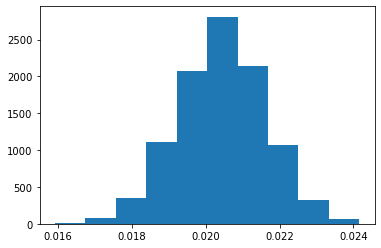

In [38]:
plt.hist(p_diffs)

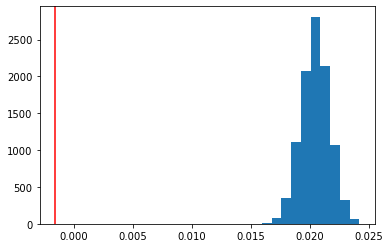

In [39]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff, color = 'red')

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [40]:
p_diffs.mean()

0.02042575531517027

In [41]:
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
print(act_diff)

-0.0015782389853555567


In [42]:
p_diffs = np.array(p_diffs)
(act_diff < p_diffs).mean()

1.0

**k.** Explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**Answer**

1. P-Value
2. The simulated statistics clearly show us that with the p-value being 1, we should defenitely stay thre null hypothesis. It means that the difference in convertion rates is truly less or closer to 0.



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [43]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2[df2['group'] == 'control']['converted'][df2['converted'] == 1].count()

# number of conversions with the new_page
convert_new = df2[df2['group'] == 'treatment']['converted'][df2['converted'] == 1].count()

# number of individuals who were shown the old_page
n_old = df2['group'][df2['group'] == 'control'].count()

# number of individuals who received new_page
n_new = df2['group'][df2['group'] == 'treatment'].count()

**m.** Now use `sm.stats.proportions_ztest()` to compute my test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

In [44]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old],alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>**Answer**

According to the results, and the data we have, it is a right-taled test. (H1: P_new > P_old)

Since Z(0.05) is 1.645 and our Z-score is -1.31 = [1.31] (Z(0.05) > Z-score), the null hypothesis cannot be rejected. This is exactly the same as what I found previously. Therefore, it can be said, that the new landing page doesn't neccesarily lead to the better conversion rates.

<a id='regression'></a>
### Part III - A regression approach

### 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Put your answer here.**

A logistic regression since the predicted response variable is limited to a probability between 0 and 1.

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [45]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [46]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

/var/folders/44/_l7p8rbj6493fqbcjc4gz6br0000gn/T/ipykernel_15294/4053050644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['intercept'] = 1
/var/folders/44/_l7p8rbj6493fqbcjc4gz6br0000gn/T/ipykernel_15294/4053050644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']


In [47]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [48]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [49]:
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-08-17 20:53 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**Clues**: 
- What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**? 
- You may comment on if these hypothesis (Part II vs. Part III) are one-sided or two-sided. 
- You may also compare the current p-value with the Type I error rate (0.05).


>**Answer**

Here, the p-value asssociated with ab_page is 0.1899. It does differ from the one we got in Part 2, since this p-value is related to the intercept, which in this case is control group. 

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Answer.**

The age of users would be a good indicator, as younger users normally tend to click on the ads. So it's possible that the landing page doesn't actually matter but the age.

But adding too many terms into a regression model is not a good idea, since the values get colapsed because of too many factors. Meaning adding too many categorical values can break the code. Also the significant bivarate relationships are notalways significant in multiple liniar regression.

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. I will read in the **countries.csv** dataset and merge together my `df2` datasets on the appropriate rows. I call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 

 I provide the statistical output as well as a written response to answer this question.

In [50]:
# Read the countries.csv
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [51]:
# Join with the df2 dataframe
df2 = pd.merge(countries, df2, on="user_id")
df2.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [52]:
# Create the necessary dummy variables
df2[['UK', 'US', 'CA']] = pd.get_dummies(df2['country'])
df2.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,ab_page,UK,US,CA
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


We can say that Canada has significantly higher conversion rates. 

**h. Fit my model and obtain the results**<br> 
Though I have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.


I'll provide the summary results (statistical output), and my conclusions (written response) based on the results. 

>**Clues**: 
- Look at all of p-values in the summary, and compare against the Type I error rate (0.05). 
- Can I reject/fail to reject the null hypotheses (regression model)?
- Comment on the effect of page and country to predict the conversion.


In [53]:
# Fit your model, and summarize the results
df2['ab_page'] = df2['ab_page']
df2['ab_UK'] = df2['ab_page'] * df2['UK']
df2['ab_US'] = df2['ab_page'] * df2['US']
df2['ab_CA'] = df2['ab_page'] * df2['CA']
df2['UK_ab_page'] = df2['UK'] * df2['ab_page']
df2['US_ab_page'] = df2['US'] * df2['ab_page']
df2['CA_ab_page'] = df2['CA'] * df2['ab_page']


lm = sm.OLS(df2['converted'], df2[['intercept', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.267
Date:                Wed, 17 Aug 2022   Prob (F-statistic):              0.280
Time:                        20:53:19   Log-Likelihood:                -85266.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290579   BIC:                         1.706e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1195      0.001    166.244      0.000       0.118       0.121
UK            -0.0008      0.004     -0.196      0.844      -0.008       0.007
US             0.0005      0.002      0.257      0.797      -0.003       0.004
UK_ab_page    -0.0069      0.005     -1.277      0.202      -0.017       0.004
US_ab_page     0.0011      0.002      0.477      0.634      -0.004       0.006
==============================================================================
Omnibus:                   125551.035   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414296.793
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**My Conclusion**

In conclusion, although there are some conversion differences between contries, it is hard to believe that the new landing page actually brings more interactions.

With that being said, the null hyposis cannot be rejected(H0 >= H1), considering all the values.